# Sentinel-1 SAR winds

Author:  Lauren Biermann, School of Biological & Marine Sciences, University of Plymouth, edited by Madeleine Martin
Credit:  This code was adapted for Ciguatoxin Aerosolization Dissertation.

In [1]:
import glob
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd
import os
import matplotlib.cm as cm #this provides colourmap access

import rasterio
from rasterio.windows import Window
from rasterio.enums import Resampling

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from windrose import WindroseAxes

import warnings
#ignorewarnings
warnings.filterwarnings("ignore")

In [2]:
# Useful functions:

def to_uv(ws, phi):
    '''
    Here phi needs to be the math angle of wind
    relative to east and positive anti-clockwise
    can be 0-360 or +-180, I think it doesn't matter
    as the function internally handles it
    e.g. to_uv(10, -45) == to_uv(10, 360-45)
    or.  to_uv(10, -90) == to_uv(10, 270)
    '''
    u = ws * np.cos(np.deg2rad(phi))
    v = ws * np.sin(np.deg2rad(phi))
    return u, v


def met2math(wdir_met):
    '''
    meteorological wdir is the from direction rel. to North
    '''
    return (270. - wdir_met)  % 360.


contour_clrs = np.array(([212, 212, 212],
                      [170,170,170],
                      [129,129,129],
                      [88,88,88],
                      [181,209,228],
                      [127,165,199],
                      [73,121,170],
                      [20, 77, 141],
                      [177, 220, 173],
                      [126,179,130],
                      [75,138,87],
                      [25,97, 45],
                      [254, 253, 174],
                      [245,186,129],
                      [237,119,84],
                      [229, 52, 39],
                      [246, 10, 29],
                      [190, 57, 194]))/255.0
levels = np.array((0, 1, 2, 3, 4, 5, 6.5, 8, 9.5, 11, 12.5, 14, 15.5, 17.5, 19.5, 21.5, 25, 30))
land_clr = (247/255, 206/255, 160/255)
mps2knots= 1.944

### Files with wind directions onshore and offshore to Aoshan Bay, Qingdao, China

In [3]:
pwd

'C:\\Users\\mkmrt\\OneDrive\\Documents\\year__3'

In [4]:
import os

# Get current working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# Change to a new directory
#new_directory = "/path/to/new/directory"  # Replace with your target directory
#os.chdir(new_directory)

# Verify the change
#print("New Directory:", os.getcwd())


Current Directory: C:\Users\mkmrt\OneDrive\Documents\year__3


In [5]:
# List of .nc files in directories
nc_winds = glob.glob('SAR/*SAFE/measurement/*.nc') # offshore winds

print(len(nc_winds))

124


### 1. MAP

ValueError: For X (0) and Y (59) with flat shading, A should have shape (58, -1, 3) or (58, -1, 4) or (58, -1) or (-58,), not (0,)

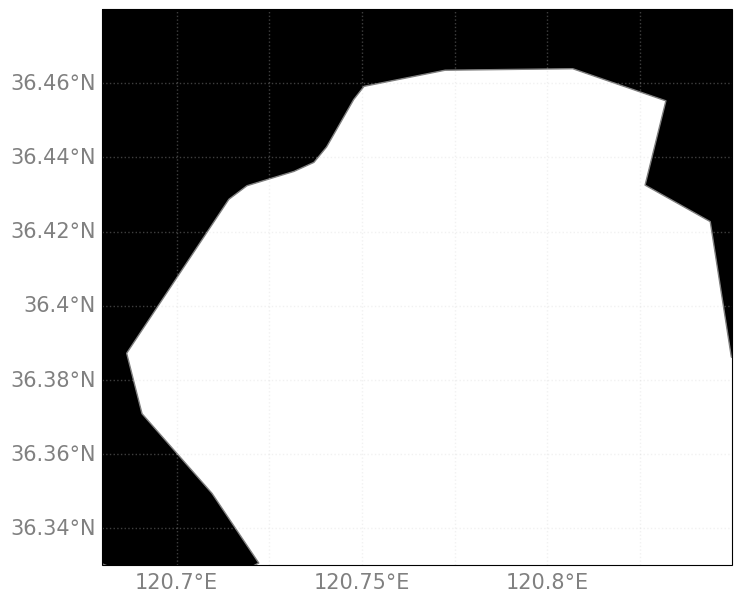

In [9]:
# Define the latitude and longitude bounds of the subset region
min_lon = 120.70
max_lon = 120.80
min_lat = 36.33
max_lat = 36.45

for file_name in nc_winds:
    # EXTRACT
    dataset = nc.Dataset(file_name)
    lat = dataset.variables['owiLat'][:]
    lon = dataset.variables['owiLon'][:]  
    owiSpd = (dataset.variables['owiWindSpeed'][:])#*2.16 #scaling factor of 2
    owiDir = dataset.variables['owiWindDirection'][:]
    # Replace fill values -999 with NaNs
    owiSpd[owiSpd == -999.0] = np.nan
    owiDir[owiDir == -999.0] = np.nan
    #owiSpd[owiSpd < 1.0] = np.nan
    
    # SUBSET
    # Find indices corresponding to latitude and longitude bounds:
    lon_indices = np.where((lon >= min_lon) & (lon <= max_lon))[1]
    lat_indices = np.where((lat >= min_lat) & (lat <= max_lat))[0]
    # Subset latitude, longitude, and wind speed arrays based on indices
    ss_lon = lon[lat_indices[0]:lat_indices[ -1 ] + 1, lon_indices[0]:lon_indices[-1] + 1]
    ss_lat = lat[lat_indices[0]:lat_indices[ -1 ] + 1, lon_indices[0]:lon_indices[-1] + 1]
    ss_Spd = owiSpd[lat_indices[0]:lat_indices[-1] + 1,lon_indices[0]:lon_indices[-1] + 1]
    ss_Dir = owiDir[lat_indices[0]:lat_indices[-1] + 1,lon_indices[0]:lon_indices[-1] + 1]

    #------------------------------------------------------------------------------------------------------------------
    # PLOT SUBSET DATA
    fig1 = plt.figure(figsize=(9, 9))
    ax = plt.axes([0.0, 0.0, 0.7, 0.7], projection=ccrs.PlateCarree())
    ax.set_extent([120.68, 120.85, 36.33, 36.48])

    # Draw gridlines and lat lon ticks on the axis
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='lightgray', alpha=0.3, linestyle=':')
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='grey', facecolor='k'))
    gl.top_labels  = False
    gl.right_labels= False
    gl.xlabel_style= {'size': 15, 'color': 'gray'}
    gl.ylabel_style= {'size': 15, 'color': 'gray'}

    # Data
    im = plt.pcolormesh(ss_lon, ss_lat, ss_Spd, cmap=plt.cm.viridis, transform=ccrs.PlateCarree()) 
    im.set_clim(5, 8)  # set the min and max for improved visualization
    # Add a colorbar
    cbar = plt.colorbar(im, orientation="horizontal", fraction=0.049, pad=0.05)
    cbar.set_label('Wind Speeds (m/s)', fontsize=15)
    cbar.ax.tick_params(labelsize=15)  
    # Add wind arrows
    uv = to_uv(ss_Spd * mps2knots, met2math(ss_Dir))
    u = uv[0]
    v = uv[1]
    i = 4
    #ax.quiver(lon[::i, ::i], lat[::i, ::i], u[::i, ::i], v[::i, ::i], transform=ccrs.PlateCarree(), color='w', scale=500)
    ax.barbs(ss_lon[::i,::i], ss_lat[::i,::i], u[::i,::i], v[::i,::i], 
         pivot = 'middle', transform = ccrs.PlateCarree(), color = 'w', rounding = True)  
    
    plt.title((f'{file_name[20:30]}'), fontsize=16, fontweight='bold', pad=14)

    # Save Figure
    save_dir = 'C:\\Users\\mkmrt\\OneDrive\\Documents\\year__3'
    os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist
    save_path = os.path.join(save_dir,f"{file_name[21:30]}_windmap.png")
    fig1.savefig(save_path, bbox_inches='tight')
    plt.close(fig1)  # Close the figure after creating it

In [7]:
# Define the latitude and longitude bounds of the subset region
min_lon = 120.68
max_lon = 120.85
min_lat = 36.33
max_lat = 36.48

### 2. WIND ROSE

Min wind speed: 13.399999618530273
Max wind speed: 22.0


<Figure size 700x700 with 0 Axes>

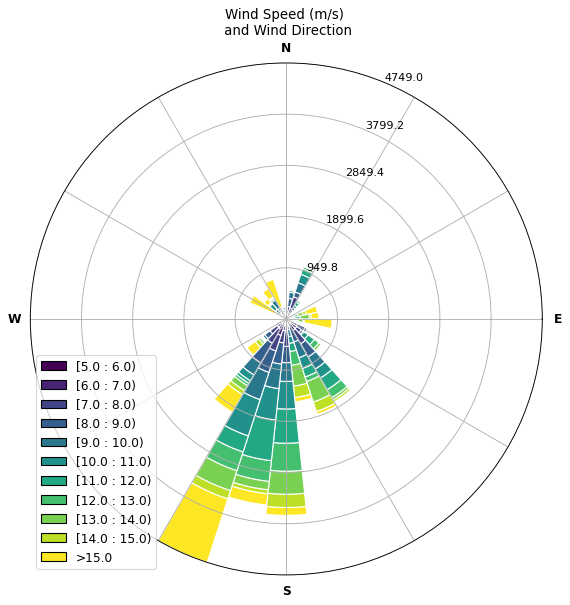

In [12]:
# Initialize lists to store ALL wind speeds and wind direction data
all_dir = []
all_vel = []

for file_name in nc_winds:
    # EXTRACT
    dataset = nc.Dataset(file_name)
    lat = dataset.variables['owiLat'][:]
    lon = dataset.variables['owiLon'][:]  
    owiSpd = (dataset.variables['owiWindSpeed'][:])*2
    owiDir = dataset.variables['owiWindDirection'][:]
    # Replace fill values -999 with NaNs
    owiSpd[owiSpd == -999.0] = np.nan
    owiDir[owiDir == -999.0] = np.nan
    owiSpd[owiSpd <= 5] = np.nan
    
    # SUBSET
    # Find indices corresponding to latitude and longitude bounds:
    lon_indices = np.where((lon >= min_lon) & (lon <= max_lon))[1]
    lat_indices = np.where((lat >= min_lat) & (lat <= max_lat))[0]
    # Subset latitude, longitude, and wind speed arrays based on indices
    ss_lon = lon[lat_indices[0]:lat_indices[-1] + 1, lon_indices[0]:lon_indices[-1] + 1]
    ss_lat = lat[lat_indices[0]:lat_indices[-1] + 1, lon_indices[0]:lon_indices[-1] + 1]
    ss_Spd = owiSpd[lat_indices[0]:lat_indices[-1] + 1, lon_indices[0]:lon_indices[-1] + 1]
    ss_Dir = owiDir[lat_indices[0]:lat_indices[-1] + 1, lon_indices[0]:lon_indices[-1] + 1]

    #------------------------------------------------------------------------------------------------------------------    
    # Append wind direction and wind speed data to the lists
    all_dir.extend(ss_Dir.ravel())
    all_vel.extend(ss_Spd.ravel())

# Create a DataFrame from the collected wind speed and wind direction data
df = pd.DataFrame({'DIR': all_dir, 'VEL': all_vel})

# Remove NaN values from the DataFrame (since we filtered wind speeds below 5 m/s)
df.dropna(inplace=True)

# Check the minimum and maximum wind speeds
print(f"Min wind speed: {df['VEL'].min()}")
print(f"Max wind speed: {df['VEL'].max()}")

# Plotting
fig4= plt.figure(figsize = (7, 7))
ax = WindroseAxes.from_ax()

# Adjust bins to represent only speeds >5 m/s 
bins = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]  # Custom bins for >5 m/s 

ax.bar(df.DIR, df.VEL, nsector = 30, opening = 1, bins = bins, cmap=cm.viridis, edgecolor='white')
# Set theta grids
ax.set_thetagrids(range(0, 360, 30), fontsize = 11, color = 'k', 
                  fontweight = 'bold')
ax.legend(prop={'size': 11}, fontsize = 11)
ax.set_title('Wind Speed (m/s) \n and Wind Direction')

# Ensure proper layout before saving
plt.tight_layout()
plt.show()




In [19]:
#fig4.savefig('WindRose_onhi.png', dpi=300)